# Sample exploration on people who has salary account with Swedbank

In [1]:
sc.defaultParallelism

40

In [1]:
# select customer who has salary account with Swedbank, and look through all the transactions with the bank. 
# Identify customers who has all the expenditure with Swedbank as well
# Identify most frequent/popular transaction types (n and amt)
# Understand how to identify transaction with self and to others

## Load packages

In [101]:
from pyspark.sql import SparkSession #可以用sql选数据了
from pyspark.sql import functions as F #a lot of functions to use
from pyspark.sql.types import StringType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time

## Creat sample dataset

In [3]:
# could create something like a macro
#transactionMonthLimits = (str('201803'), str('201805'))
#trans_18_0305 = spark.sql('select * from ddp_central.depo_transactionext where bankid = "8999"\
#                        and transactionmonth between %s and %s' % transactionMonthLimits)\
# sel_col = ['transactiontype','productname'\
#          ,'productdescription','productgrouplevel1','productgrouplevel2'] 
# trans_prod.groupBy(sel_col).count().sort(asc('transactiontype')).show(7, False)


# could create columns in the sql step
#        .withColumn('accountingtypecd', trim(trans_test.accountingtypecd))\
#       .withColumn('amount', trans_test.amount.cast(DecimalType(16,2)))\
#       .withColumn('toSelf', when(trans_test.primaryaccountholder == trans_test.secpartygenid, 1).otherwise(0))\
#       .withColumn('toOther', when(trans_test.primaryaccountholder != trans_test.secpartygenid, 1).otherwise(0))\
#       .withColumn('count', lit(1))\

In [2]:
# # collect customer and their transactions and transaction types
MonthtoLimit = (str('201808'), str('201805'))

trx_sample=spark.sql('select trx.*, trx_type.* \
            from (select distinct primaryaccountholder \
            from ddp_central.depo_transactionext where transactionmonth>=%s and trim(transtypecd) in ("TOB153","TOB447") \
            and bankid="8999")  ppl \
            inner join (select * from ddp_central.depo_transactionext where transactionmonth>=%s and bankid="8999" ) trx \
            on ppl.primaryaccountholder=trx.primaryaccountholder \
            left join ddp_central.amtr_transactiontype as trx_type on trim(trx.transtypecd)=trim(trx_type.transactiontypecd)' \
                    % MonthtoLimit)\
        .dropDuplicates()\
        .drop("transactiontypecd")\
        .withColumn("partygenid",F.base64(F.col("primaryaccountholder")))\
        .withColumn("secpartygenid",F.base64(F.col("secpartygenid")))\
        .withColumn('transtypecd', F.trim(F.col('transtypecd')))\
        .orderBy(F.col('primaryaccountholder'))

In [3]:
trx_sample.columns

['primaryaccountholder',
 'agreementgenid',
 'productgenid',
 'transtypecd',
 'transactiondate',
 'accountingtypecd',
 'channeltypecd',
 'amount',
 'bankid',
 'secaccounttypecd',
 'secclearingnum',
 'secaccountnum',
 'secagreementgenid',
 'secpartygenid',
 'secproductgenid',
 'channelgenid',
 'transactiongenid',
 'systemsourcecd',
 'identificationmethodcd',
 'paymentroutinecd',
 'secbic',
 'clearingnum',
 'cardtransactionchannelcd',
 'transactioninfo',
 'kanalgenid',
 'transactionmonth',
 'transactiontype',
 'transactiongroupcd',
 'transactiongroup',
 'partygenid']

In [4]:
trx_sample.select("partygenid").distinct().count()

485279

In [ ]:
trx_sample.show(3)

In [122]:
# add customer infor (age, marital status, number of kids, address to identify same household)
#select swedbank customers that are active (can also specify customerstartdate>="2014-01-01", customerstartdate<="2014-01-31")
part_party = spark.sql('select partygenid, birthdate, age, gender, customerstartdate from ddp_central.part_party \
             where bankid = "8999" and customernumtypecd="FYS" and deceased<>"J" and validtodate="2999-12-31"')\
            .withColumn("partygenid",F.base64(F.col("partygenid")))\
            .dropDuplicates()

In [ ]:
part_party.columns

In [6]:
part_party.select("partygenid").distinct().count()

6213690

In [123]:
part_party.show(3)

+----------------+----------+---+------+-----------------+
|      partygenid| birthdate|age|gender|customerstartdate|
+----------------+----------+---+------+-----------------+
|GZcGAhYYVnWGMQ==|1994-12-01| 24|     M|       1995-06-21|
|FQUBACFYAABhWQ==|2014-10-18|  4|     M|       2015-04-30|
|GZcJAxYZJCcolQ==|1947-06-05| 71|     M|       1997-08-25|
+----------------+----------+---+------+-----------------+
only showing top 3 rows



### maybe need to map household. identify transactions within customer's own accounts when customer is the primary account owner for both of the account.
#### create a group variable to refer to household counting, then map it to primary accountholder, so household group will be the key.

In [140]:
#ddp_central.partaddress, if live at the same address, then household
#ddp_central.src_sdw_agreementcustomerrole (agreementgenid, agreementbankid, agreementstatus,agmtstartdate,agmtenddate, 
#partygenid_role, customerroletype, customerrolestartdate, customerroleenddate)

household=spark.sql('select a.agreementgenid, a.agreementbankid, a.agreementstatus, a.agmtstartdate, a.agmtenddate, \
a.partygenid_role, a.customerroletype, a.customerrolestartdate, a.customerroleenddate, b.partygenid_role as partygenid_role_sec, \
c.productname, c.productgrouplevel1, c.productgrouplevel2, c.productgrouplevel3 from ddp_central.src_sdw_agreementcustomerrole as a \
inner join (select agreementgenid, partygenid_role from ddp_central.src_sdw_agreementcustomerrole where customerroletype in ("01") and agreementbankid="8999") as b on a.agreementgenid=b.agreementgenid \
inner join (select partygenid, birthdate, age, gender, customerstartdate from ddp_central.src_sdw_part_party \
where bankid = "8999" and customernumtypecd="FYS" and deceased<>"J" and validtodate="2999-12-31") as d on a.partygenid_role=d.partygenid \
left join ddp_central.src_sdw_prd_productstructgpx as c on a.produktgenid=c.productgenid where a.agreementbankid="8999" and a.customerroletype in ("00") order by a.agreementgenid')\
.withColumn("partygenid",F.base64(F.col("partygenid_role")))\
.withColumn("partygenid_sec",F.base64(F.col("partygenid_role_sec")))\
.withColumn("ID", F.monotonically_increasing_id())\
.select("agreementgenid", "partygenid", "partygenid_sec", "ID")


In [4]:
#map secparty's role customerroletype in ("00", "01") and 

household=spark.sql('select a.*, b.customerroletype as sec_role from ddp_steer.p901cyo_trx_sample_201805_201808 as a \
left join (select agreementgenid, partygenid_role, customerroletype from ddp_central.src_sdw_agreementcustomerrole \
where agreementbankid="8999" and customerroletype in ("00", "01", "02", "13")) as b \
on a.agreementgenid=b.agreementgenid and a.secpartygenid=base64(b.partygenid_role)')

In [7]:
#household.show(5)
household.groupby('sec_role').count().show()

+--------+---------+
|sec_role|    count|
+--------+---------+
|      01|  7234087|
|    null| 18232750|
|      00|164847597|
|      02|  1921820|
|      13|      957|
+--------+---------+



### combine party, household data with transaction data (tbd)

In [7]:
trx_ppl=trx_sample\
        .join(part_party,['partygenid'], 'inner')

In [8]:
trx_ppl.select("partygenid").distinct().count()

484321

In [ ]:
# cache the table for later use
start = time.time()
trx_ppl.cache().count()
end = time.time()

#trx_sample.is_cached
#  useDisk, useMemory, useOffHeap, deserialized, replication=1
#trx_sample.storageLevel
#spark.catalog.clearCache()
#spark.catalog.uncacheTable(tableName='trx_sample')

In [ ]:
print(end - start)

In [11]:
trx_ppl.is_cached

False

In [9]:
# save the table on Hive for common use
trx_ppl.write.format('orc').saveAsTable('ddp_steer.p901cyo_trx_sample_201805_201808', mode = 'overwrite')

In [ ]:
# find transaction has the highest frequency
trx_freq_output=trx_ppl.groupby("transtypecd", "transactiontype", "accountingtypecd").count().\
sort(F.desc("count"))

In [ ]:
#look into ATL and TOB transactions separately
trx_ppl.filter(F.col('transtypecd').like('%ATL%')).groupby("transtypecd","transactiontype", "accountingtypecd").count().show()

In [ ]:
trx_ppl.filter(F.col('transtypecd').like('%TOB%')).groupby("transtypecd", "transactiontype", "accountingtypecd").count().\
sort(F.desc("count")).show(100)

In [ ]:
# find transaction has the highest amount
    #look the average amount first
trx_ppl.groupby("transtypecd", "transactiontype", "accountingtypecd").agg({'amount':'mean'}).\
sort(F.desc('avg(amount)')).show(100)
    #look at total amount
trx_amt_output=trx_ppl.groupby("transtypecd", "transactiontype", "accountingtypecd").agg(F.sum('amount')).\
sort(F.desc('sum(amount)'))

In [ ]:
# put volumn and amount count in one table
trx_summary=trx_freq_output.join(trx_amt_output,['transtypecd','transactiontype','accountingtypecd'],'left')
trx_summary.show(10)
    #output the summary table
trx_summary.to_csv(os.path.join('~/repos', 'transtype_freq' + '.csv'), encoding='utf-8')

## High level exploration

In [44]:
aggregate_trx=spark.sql('select partygenid, transactionmonth, accountingtypecd, count(*) as trx_n, \
sum(amount) as trx_amt from ddp_steer.p901cyo_trx_sample_201805_201808 group by partygenid, transactionmonth, accountingtypecd')

In [45]:
agg_trx_pd=aggregate_trx.toPandas()

In [47]:
agg_trx_pd.head(10)

,partygenid,transactionmonth,accountingtypecd,trx_n,trx_amt
0,6uC9X9OIG5IAAA==,201807,UT,53,-91457.86
1,BwYhABREAAEVgg==,201807,UT,77,-38220.68
2,CAUVABImAABZcA==,201807,UT,37,-13990.69
3,CREGAVUVAAQlIQ==,201808,IN,9,59643.00
4,DKa7+9BceMYAAA==,201808,IN,5,12222.98
5,EAkHABUZAACAIQ==,201806,UT,38,-25737.31
6,EBEwABIYAAJBFQ==,201805,UT,101,-101090.04
7,EQMSABJJAACAYw==,201808,UT,30,-5772.05
8,EQYjABJEAABiRw==,201806,UT,21,-6869.74
9,EQgYABIpAAETJw==,201807,UT,36,-170009.51


In [84]:
plt.figure()
#agg_trx_pd.trx_n.plot()
plt.show()

TypeError: unsupported operand type(s) for +: 'Decimal' and 'float'

## transtype_freq file helps to decide what transaction types to focus on.

In [1]:
#	transtypecd	transactiontype	Type1	Type2
#	TOB038	ROBUR	investment related	offset each other
#	TOB050	Ã–verfÃ¶ring		
#	TOB104	BANK VIA TELEFON		
#	TOB153	LÃ¶n	cash inflow	income
#	TOB155	Pension	cash inflow	income
#	TOB218	bostadsbidrag	cash inflow	allowance
#	TOB255	SWISH MOTTAGEN	Swish	offset other swish type transaction
#	TOB256	SWISH SKICKAD	Swish	offset other swish type transaction
#	TOB261	KONTOKÃ–P KORT	in and out	offset
#	TOB335	Utdelning	cash inflow	unstable income
#	TOB344	SÃ¤lj enl. fondnota	investment related	offset each other
#	TOB345	KÃ¶p enl. fondnota	investment related	offset each other
#	TOB349	Swish	Swish	offset other swish type transaction
#	TOB353	Swish retur 	Swish	offset other swish type transaction
#	TOB364	Bankomatuttag	cash outflow	pure cost
#	TOB366	InsÃ¤ttningsautomat	cash inflow	offset ATM take out
#	TOB390	Pension KPA	cash inflow	income
#	TOB407	CSN	cash inflow	income and cost
#	TOB409	DagsersÃ¤ttning	cash inflow	allowance
#	TOB430	ISK INSÃ„TTNING	ISK	offset each other
#	TOB431	ISK UTTAG	ISK	offset each other
#	TOB432	ISK omplacering	ISK	don't understand
#	TOB452	Folksam	cash inflow	unstable income
#	TOB486	Autogiro	cash outflow	pure cost
#	TOB490	Ã–verfÃ¶ring via telefon 		
#	TOB500	Barnbidrag	cash inflow	allowance
#	TOB521	InsÃ¤ttning	investment related	moving money from income to saving
#	TOB522	Uttag	cash outflow	pure cost
#	TOB549	Girobetalning	cash outflow	pure cost
#	TOB550	PG-BET. VIA INTERNET	cash outflow	pure cost
#	TOB551	BG-BET. VIA INTERNET	cash outflow	pure cost
#	TOB552	Ã–verfÃ¶ring via Internet		
#	TOB553	Egen Ã¶verfÃ¶ring		
#	TOB555	Direktbetalning	cash outflow	pure cost
#	TOB563	Debiteringsavgift	cash outflow	pure cost
#	TOB571	Bankgiro inbetalning	cash inflow	offset bankgiro cost
#	TOB573	Autogiro Inbetalning	cash inflow	offset autogiro cost
#	TOB580	INSÃ„TTNING FASTRÃ„NTA	investment related	moving money from income to saving
#	TOB583	AVSLUT FASTRÃ„NTEKONTO	cash inflow	offset TOB584
#	TOB584	AVSLUT FASTRÃ„NTEKONTO	cash outflow	offset TOB583
#	TOB588	BG KONTOINSÃ„TTNING	cash inflow	unstable income
#	TOB605	SWEDBANK FÃ–RSÃ„KRING AB	in and out	offset
#	TOB625	Slutlikvid lÃ¤genhet/fastighet	cash inflow	special type of income
#	TOB663	Swish	Swish	offset other swish type transaction
#	TOB665	Swish retur	Swish	offset other swish type transaction
#	TOB684	IP-Omplacering	cash inflow	don't understand
#	TOB707	LÃ¥n/placering	cash inflow	loan, temporary income
#	TOB801	Ã–verfÃ¶ring lÃ¥n	cash outflow	pure cost
#	TOB954	FK/PMYND	cash inflow	allowance
#	TOB873	Europabetalning IN	Europa	offset each other
#	TOB852 	Europabetalning UT	Europa	offset each other
#	TOB946	 underhållsstöd	cash inflow	allowance

### 1. look at income source

In [102]:
#income_list=["TOB153", "TOB155", "TOB390", "TOB407", "TOB447", "TOB452", "TOB588", "TOB589", "TOB680", "TOB954", 
#"TOB218", "TOB287", "TOB409", "TOB500", "TOB946",
#"TOB197", "TOB210", "TOB239", "TOB335", "TOB625", "TOB707", "TOB521"]

#TOB153	LÃ¶n	 Income 
#TOB155	Pension	 Income 
#TOB390	Pension KPA	 Income 
#TOB407	CSN	 Income 
#TOB447	LÃ¶n	 Income
#TOB452	Folksam	income
#TOB588	BG KONTOINSÃ„TTNING	income
#TOB589	BG KONTOINSÃ„TTNING	income
#TOB680	IP-Inbetalning	income (pension)
#TOB954	FK/PMYND	 income seems that some sort of allowance from the government (pension)

#TOB218 bostadsbidrag
#TOB287 Arbetslöshetskassa
#TOB409 Dagsersättning
#TOB500	Barnbidrag	Income
#TOB946 underhållsstöd
#TOB952 FAMILJEBIDRAG

#TOB197	SparrÃ¤nta	 income

#TOB210	Traktamente	 income
#TOB212	SemesterersÃ¤ttning

#TOB239	VP-Utdelning	 income
#TOB335	Utdelning	 income 
#TOB625	Slutlikvid lÃ¤genhet/fastighet	 in 
#TOB707	LÃ¥n/placering	 in 

#TOB521	InsÃ¤ttning	 income transfer money from other accounts to Swedbank accounts

TOB_income=spark.sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd in ("TOB153", "TOB155", "TOB390", "TOB407", "TOB447", "TOB452", "TOB500", "TOB588", "TOB589", "TOB680", "TOB954", \
"TOB218", "TOB287", "TOB409", "TOB946", "TOB952", \
"TOB197", "TOB210","TOB212", "TOB239", "TOB335", "TOB625", "TOB707", "TOB521") sort by partygenid, transactiondate')\
                .withColumn('count', F.lit(1))

In [103]:
sum_income=TOB_income.select('partygenid','amount','transactiondate','count').groupby('transactiondate')\
.agg(F.count('partygenid'), F.count('count'), F.avg('amount'), F.sum('amount'))\
.sort('transactiondate')

In [104]:
sum_income.show(5)

Py4JJavaError: An error occurred while calling o1060.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 355.0 failed 4 times, most recent failure: Lost task 1.3 in stage 355.0 (TID 11452, sb-hdp-d10.fspa.myntet.se, executor 229): org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.security.token.SecretManager$InvalidToken): token (HDFS_DELEGATION_TOKEN token 557011 for p901cyo) can't be found in cache
	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1554)
	at org.apache.hadoop.ipc.Client.call(Client.java:1498)
	at org.apache.hadoop.ipc.Client.call(Client.java:1398)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Invoker.invoke(ProtobufRpcEngine.java:233)
	at com.sun.proxy.$Proxy15.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.getFileInfo(ClientNamenodeProtocolTranslatorPB.java:823)
	at sun.reflect.GeneratedMethodAccessor4.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:291)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:203)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:185)
	at com.sun.proxy.$Proxy16.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.getFileInfo(DFSClient.java:2165)
	at org.apache.hadoop.hdfs.DistributedFileSystem$26.doCall(DistributedFileSystem.java:1442)
	at org.apache.hadoop.hdfs.DistributedFileSystem$26.doCall(DistributedFileSystem.java:1438)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.getFileStatus(DistributedFileSystem.java:1454)
	at org.apache.spark.deploy.SparkHadoopUtil.listLeafStatuses(SparkHadoopUtil.scala:194)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$.listOrcFiles(OrcFileOperator.scala:94)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$.getFileReader(OrcFileOperator.scala:67)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$$anonfun$readSchema$1.apply(OrcFileOperator.scala:77)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$$anonfun$readSchema$1.apply(OrcFileOperator.scala:77)
	at scala.collection.TraversableLike$$anonfun$flatMap$1.apply(TraversableLike.scala:241)
	at scala.collection.TraversableLike$$anonfun$flatMap$1.apply(TraversableLike.scala:241)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at scala.collection.TraversableLike$class.flatMap(TraversableLike.scala:241)
	at scala.collection.immutable.List.flatMap(List.scala:344)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$.readSchema(OrcFileOperator.scala:77)
	at org.apache.spark.sql.hive.orc.OrcFileFormat$$anonfun$buildReader$2.apply(OrcFileFormat.scala:137)
	at org.apache.spark.sql.hive.orc.OrcFileFormat$$anonfun$buildReader$2.apply(OrcFileFormat.scala:131)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:136)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:120)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:124)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:174)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:105)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.sort_addToSorter$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.agg_doAggregateWithKeys$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:395)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:123)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1517)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1505)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1504)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1504)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:814)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:814)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1732)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1687)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1676)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:630)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2029)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$reduce$1.apply(RDD.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1008)
	at org.apache.spark.rdd.RDD$$anonfun$takeOrdered$1.apply(RDD.scala:1429)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1416)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:133)
	at org.apache.spark.sql.Dataset.org$apache$spark$sql$Dataset$$collectFromPlan(Dataset.scala:2861)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2150)
	at org.apache.spark.sql.Dataset$$anonfun$head$1.apply(Dataset.scala:2150)
	at org.apache.spark.sql.Dataset$$anonfun$55.apply(Dataset.scala:2842)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:2841)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2150)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2363)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:241)
	at sun.reflect.GeneratedMethodAccessor175.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.security.token.SecretManager$InvalidToken): token (HDFS_DELEGATION_TOKEN token 557011 for p901cyo) can't be found in cache
	at org.apache.hadoop.ipc.Client.getRpcResponse(Client.java:1554)
	at org.apache.hadoop.ipc.Client.call(Client.java:1498)
	at org.apache.hadoop.ipc.Client.call(Client.java:1398)
	at org.apache.hadoop.ipc.ProtobufRpcEngine$Invoker.invoke(ProtobufRpcEngine.java:233)
	at com.sun.proxy.$Proxy15.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.protocolPB.ClientNamenodeProtocolTranslatorPB.getFileInfo(ClientNamenodeProtocolTranslatorPB.java:823)
	at sun.reflect.GeneratedMethodAccessor4.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invokeMethod(RetryInvocationHandler.java:291)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:203)
	at org.apache.hadoop.io.retry.RetryInvocationHandler.invoke(RetryInvocationHandler.java:185)
	at com.sun.proxy.$Proxy16.getFileInfo(Unknown Source)
	at org.apache.hadoop.hdfs.DFSClient.getFileInfo(DFSClient.java:2165)
	at org.apache.hadoop.hdfs.DistributedFileSystem$26.doCall(DistributedFileSystem.java:1442)
	at org.apache.hadoop.hdfs.DistributedFileSystem$26.doCall(DistributedFileSystem.java:1438)
	at org.apache.hadoop.fs.FileSystemLinkResolver.resolve(FileSystemLinkResolver.java:81)
	at org.apache.hadoop.hdfs.DistributedFileSystem.getFileStatus(DistributedFileSystem.java:1454)
	at org.apache.spark.deploy.SparkHadoopUtil.listLeafStatuses(SparkHadoopUtil.scala:194)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$.listOrcFiles(OrcFileOperator.scala:94)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$.getFileReader(OrcFileOperator.scala:67)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$$anonfun$readSchema$1.apply(OrcFileOperator.scala:77)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$$anonfun$readSchema$1.apply(OrcFileOperator.scala:77)
	at scala.collection.TraversableLike$$anonfun$flatMap$1.apply(TraversableLike.scala:241)
	at scala.collection.TraversableLike$$anonfun$flatMap$1.apply(TraversableLike.scala:241)
	at scala.collection.immutable.List.foreach(List.scala:381)
	at scala.collection.TraversableLike$class.flatMap(TraversableLike.scala:241)
	at scala.collection.immutable.List.flatMap(List.scala:344)
	at org.apache.spark.sql.hive.orc.OrcFileOperator$.readSchema(OrcFileOperator.scala:77)
	at org.apache.spark.sql.hive.orc.OrcFileFormat$$anonfun$buildReader$2.apply(OrcFileFormat.scala:137)
	at org.apache.spark.sql.hive.orc.OrcFileFormat$$anonfun$buildReader$2.apply(OrcFileFormat.scala:131)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:136)
	at org.apache.spark.sql.execution.datasources.FileFormat$$anon$1.apply(FileFormat.scala:120)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.org$apache$spark$sql$execution$datasources$FileScanRDD$$anon$$readCurrentFile(FileScanRDD.scala:124)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:174)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:105)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.sort_addToSorter$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.agg_doAggregateWithKeys$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIterator.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$8$$anon$1.hasNext(WholeStageCodegenExec.scala:395)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:123)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:108)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:338)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [60]:
sum_income_pd=sum_income.withColumn("sum_amount_int", F.col("sum(amount)").cast("bigint")).drop('sum(amount)')\
                        .withColumn("avg_amount_int", F.col("avg(amount)").cast("bigint")).drop('avg(amount)')\
                        .toPandas()\
                        .sort_values(by=['transactiondate'])

In [61]:
sum_income_pd.head(5)

,transactiondate,sum_amount_int,avg_amount_int
20,2018-05-01,13213,1651
84,2018-05-02,271761631,33763
72,2018-05-03,120144491,12051
23,2018-05-04,164027369,15609
46,2018-05-07,123314955,11338


In [32]:
type(sum_income['sum(amount)'])

pandas.core.series.Series

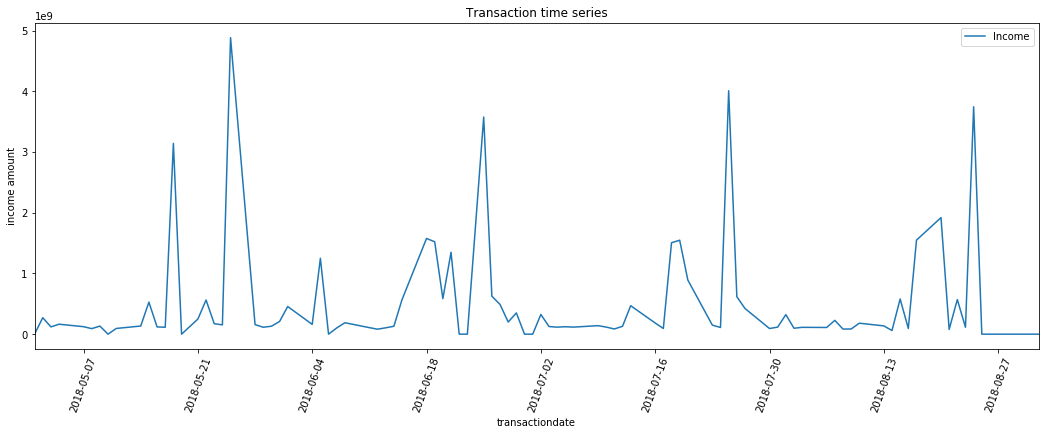

In [46]:
plt.clf
y_values = ['sum_amount_int']
sum_income_pd.plot(x='transactiondate', y='sum_amount_int', figsize = (18, 6), label = 'Income', rot = 70)
plt.ylabel('income amount')
plt.title('Transaction time series')
plt.show()

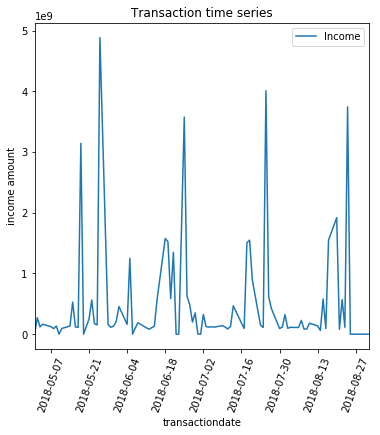

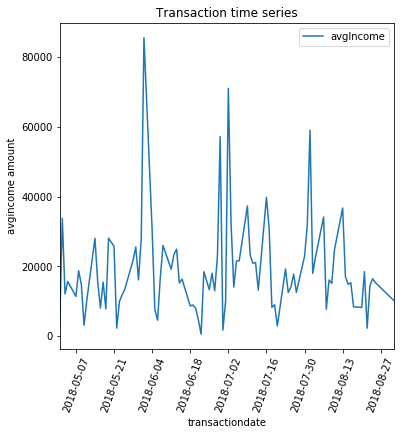

In [77]:

plt.clf
sum_income_pd.plot(x='transactiondate', y='sum_amount_int', figsize = (6, 6), label = 'Income', rot = 70)
plt.ylabel('income amount')
plt.title('Transaction time series')
plt.show()

plt.clf
sum_income_pd.plot(x='transactiondate', y='avg_amount_int', figsize = (6, 6), label = 'avgIncome', rot = 70)
plt.ylabel('avgincome amount')
plt.title('Transaction time series')
plt.show()

In [5]:
print("Partitions: " + str(TOB_income.rdd.getNumPartitions()) )

Partitions: 29


In [44]:
type(TOB_income.rdd.mapPartitions(2))

pyspark.rdd.PipelinedRDD

In [309]:
%time
print(TOB_income.count())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
2191140


In [4]:
TOB_income.show(100)

+----------------+--------------------+--------------+--------------------+-----------+---------------+----------------+-------------+--------+------+----------------+--------------+-------------+-----------------+-------------+---------------+------------+----------------+--------------+----------------------+----------------+------+-----------+------------------------+----------------+-------------+----------------+------------------+------------------+--------------------+----------+---+------+-----------------+-----+
|      partygenid|primaryaccountholder|agreementgenid|        productgenid|transtypecd|transactiondate|accountingtypecd|channeltypecd|  amount|bankid|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|secpartygenid|secproductgenid|channelgenid|transactiongenid|systemsourcecd|identificationmethodcd|paymentroutinecd|secbic|clearingnum|cardtransactionchannelcd| transactioninfo|   kanalgenid|transactionmonth|   transactiontype|transactiongroupcd|    transactio

In [337]:
TOB_income.select("birthdate", "partygenid", "transactionmonth","transtypecd","amount").orderBy(F.desc("birthdate")).show(100)

+----------+----------------+----------------+-----------+--------+
| birthdate|      partygenid|transactionmonth|transtypecd|  amount|
+----------+----------------+----------------+-----------+--------+
|2015-10-01|FxATABIpAAUQGQ==|          201807|     TOB153|  171.14|
|2015-10-01|FxATABIpAAUQGQ==|          201806|     TOB153|  171.14|
|2015-10-01|FxATABIpAAUQGQ==|          201808|     TOB153|  171.14|
|2015-10-01|FxATABIpAAUQGQ==|          201805|     TOB153|  171.14|
|2015-09-13|FgQSABEnAAFUkw==|          201807|     TOB153|  177.99|
|2015-09-13|FgQSABEnAAFUkw==|          201805|     TOB153|   68.41|
|2015-09-13|FgQSABEnAAFUkw==|          201807|     TOB153|   68.41|
|2015-09-13|FgQSABEnAAFUkw==|          201806|     TOB153|   68.41|
|2015-09-13|FgQSABEnAAFUkw==|          201808|     TOB153|   68.41|
|2015-08-31|FxAYABURAABYJg==|          201807|     TOB153|  530.50|
|2015-08-31|FxAYABURAABYJg==|          201805|     TOB153|  530.50|
|2015-08-31|FxAYABURAABYJg==|          201808|  

In [362]:
Income=TOB_income.groupby("partygenid", "transactionmonth", "transtypecd")\
             .agg(F.sum(F.col("amount")), F.count(F.col("amount")))\
             .withColumn('sum_income', F.col("sum(amount)"))\
             .withColumn('count_income', F.col("count(amount)"))\
             .drop('sum(amount)','count(amount)')\
             .orderBy("partygenid", "transactionmonth", "transtypecd")
Income.columns

['partygenid', 'transactionmonth', 'transtypecd', 'sum_income', 'count_income']

### 2. Look at cost source

In [498]:
#cost_list=["TOB364", "TOB486", "TOB522", "TOB549", "TOB550", "TOB551", "TOB555", "TOB563", "TOB801",
#"TOB366", "TOB571", "TOB573", 
#"TOB261", "TOB602",
#"TOB349", "TOB353", "TOB663", "TOB665", "TOB255", "TOB256", 
#"TOB852", "TOB873", 
#"TOB583", "TOB584"]

#TOB364	Bankomatuttag	cost
#TOB486	Autogiro	cost
#TOB522	Uttag	cost
#TOB549	Girobetalning	cost
#TOB550	PG-BET. VIA INTERNET	 cost 
#TOB551	BG-BET. VIA INTERNET	cost
#TOB555	Direktbetalning	cost
#TOB563	Debiteringsavgift	cost
#TOB801	Ã–verfÃ¶ring lÃ¥n	cost

#TOB366	InsÃ¤ttningsautomat	 seems like something related to atm machine, the opposite of Bankomatuttag 
#TOB571	Bankgiro inbetalning	net cost
#TOB573	Autogiro Inbetalning	 net cost 

#TOB261	KONTOKÃ–P KORT	 in and out 
#TOB605	SWEDBANK FÃ–RSÃ„KRING AB	 in and out 

#TOB349	Swish p to c
#TOB353	Swish retur return money
#TOB663	Swish
#TOB665	Swish retur
#TOB255	SWISH MOTTAGEN p to p
#TOB256	SWISH SKICKAD p to p

#TOB852 Europabetalning UT
#TOB873 Europabetalning IN

#TOB583	AVSLUT FASTRÃ„NTEKONTO
#TOB584	AVSLUT FASTRÃ„NTEKONTO

TOB_cost=spark.sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd in ( \
                   "TOB364", "TOB486", "TOB522", "TOB549", "TOB550", "TOB551", "TOB555", "TOB563", "TOB801", \
"TOB366", "TOB571", "TOB573",  \
"TOB261", "TOB602", \
"TOB349", "TOB353", "TOB663", "TOB665", "TOB255", "TOB256", \
"TOB873", "TOB852", \
"TOB583", "TOB584")\
sort by partygenid, transactiondate')\
                .withColumn('count', F.lit(1))

In [369]:
cost=TOB_cost.filter((F.col("transtypecd")!= "TOB571") & (F.col("transtypecd")!= "TOB573"))\
             .groupby("partygenid", "transactionmonth", "transtypecd")\
             .agg(F.sum(F.col("amount")), F.count(F.col("amount")))\
             .withColumn('sum_cost', F.col("sum(amount)"))\
             .withColumn('count_cost', F.col("count(amount)"))\
             .drop('sum(amount)','count(amount)')\
             .orderBy("partygenid", "transactionmonth", "transtypecd")
cost.columns

['partygenid', 'transactionmonth', 'transtypecd', 'sum_cost', 'count_cost']

In [370]:
#transaction types which will net the cost
cost_net=TOB_cost.filter((F.col("transtypecd")== "TOB571") | (F.col("transtypecd")== "TOB573"))\
             .groupby("partygenid", "transactionmonth", "transtypecd")\
             .agg(F.sum(F.col("amount")), F.count(F.col("amount")))\
             .withColumn('sum_cost_net', F.col("sum(amount)"))\
             .withColumn('count_cost_net', F.col("count(amount)"))\
             .drop('sum(amount)','count(amount)')\
             .orderBy("partygenid", "transactionmonth", "transtypecd")
cost_net.columns

['partygenid',
 'transactionmonth',
 'transtypecd',
 'sum_cost_net',
 'count_cost_net']

#### detail look into Swish: basically just need to get a net result from Swish, then add into the overal economy. put all the swish transaction types into cost side for now

In [379]:
Swish=spark.sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd in ("TOB255", "TOB348", "TOB665", "TOB664", "TOB256", "TOB663", "TOB349", "TOB353") sort by partygenid, transactiondate')\
                .withColumn('count', F.lit(1))\
                .groupby("partygenid", "transactionmonth")\
                .agg(F.sum(F.col("amount")), F.count(F.col("amount")))\
                .withColumn('sum_cost_swish', F.col("sum(amount)"))\
                .withColumn('count_cost_swish', F.col("count(amount)"))\
                .select('partygenid', 'transactionmonth', 'sum_cost_swish','count_cost_swish')\
                .withColumn('transtypecd', F.lit("Swish"))\
                .orderBy("partygenid", "transactionmonth")
Swish.columns

['partygenid',
 'transactionmonth',
 'sum_cost_swish',
 'count_cost_swish',
 'transtypecd']

#### detail look into Europabetalning
##### seems that mainly old people use this method?

In [501]:
Europa=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where upper(transactiontype) like "%EUROPA%" sort by partygenid, transactiondate')\
                .withColumn('count', F.lit(1))

In [512]:
Europa.groupby("transtypecd","transactiontype", "accountingtypecd").count().sort(F.desc("count")).show()

+-----------+--------------------+----------------+-----+
|transtypecd|     transactiontype|accountingtypecd|count|
+-----------+--------------------+----------------+-----+
|     TOB873|     Europabetalning|             IN |48281|
|     TOB852|     Europabetalning|             UT |19959|
|     TOB853|    Europabet urgent|             UT |  343|
|    ATL0873|EUROPABETALNING  ...|             IN |  102|
|    ATL0852|EUROPABETALNING  ...|             UT |   95|
|     TOB852|     Europabetalning|             IN |   34|
|     TOB833|     Europabetalning|             IN |    3|
+-----------+--------------------+----------------+-----+



In [517]:
age_histogram = Europa.select('age').rdd.flatMap(lambda x: x).histogram(11)

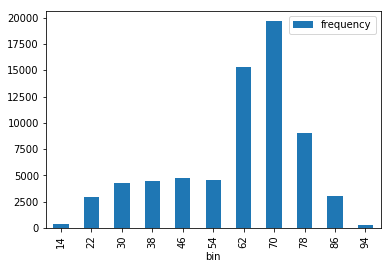

In [518]:
pd.DataFrame(
    list(zip(*age_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')
plt.show()

#### detail look into avslut fasträntekonton

In [528]:
sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where upper(transactiontype) like "%AVSLUT%" sort by partygenid, transactiondate')\
                .withColumn('count', F.lit(1)).groupby("transactiontype","transtypecd","accountingtypecd").count().show()

+--------------------+-----------+----------------+-----+
|     transactiontype|transtypecd|accountingtypecd|count|
+--------------------+-----------+----------------+-----+
|AVSLUT FASTRÄNTEK...|     TOB584|             UT | 2154|
|RÄTTNING / AVSLUT...|     TOB795|             IN |   22|
|              Avslut|     TOB399|             UT | 3124|
|Avslutningsdifferens|     TOB200|             IN |  167|
|AVSLUT FASTRÄNTEK...|     TOB583|             IN | 2220|
|              Avslut|     TOB399|             IN |    7|
|Avslutningsdifferens|     TOB200|             UT |   68|
+--------------------+-----------+----------------+-----+



#### detail look into ISK
##### Suggest not to consider any ISK related transaction due to the fact that in/ut from ISK account are not really related to income and cost. losing money on the ISK won't incur extra cost and wining money on the ISK can bring extra income but uncertain income. utdelning has been considered in the income at this stage, however, maybe it shouldn't as it is not a certain income in a sense.

In [513]:
ISK=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where upper(transactiontype) like "%ISK%" sort by partygenid, transactiondate')\
                .withColumn('count', F.lit(1))

In [514]:
ISK.groupby("transactiontype", "transtypecd", "accountingtypecd").count().orderBy("transactiontype", "transtypecd").show()

+--------------------+-----------+----------------+------+
|     transactiontype|transtypecd|accountingtypecd| count|
+--------------------+-----------+----------------+------+
|      ISK INSÄTTNING|     TOB430|             IN |245492|
|      ISK INSÄTTNING|     TOB430|             UT |     5|
|           ISK UTTAG|     TOB431|             UT | 36863|
|ISK flytt egen extut|     TOB436|             UT |    64|
|ISK flytt egna extin|     TOB435|             IN |    91|
|ISK flytt egna in...|     TOB434|             IN |     7|
|ISK flytt egna in...|     TOB434|             UT |     7|
|  ISK från annans in|     TOB438|             IN |    13|
|     ISK omplacering|     TOB432|             UT |402793|
|     ISK omplacering|     TOB432|             IN | 26876|
|  ISK till annans ut|     TOB439|             UT |     3|
+--------------------+-----------+----------------+------+



In [526]:
age_histogram = ISK.select('age').rdd.flatMap(lambda x: x).histogram(11)

In [525]:
age_histogram

([7.0,
  15.363636363636363,
  23.727272727272727,
  32.09090909090909,
  40.45454545454545,
  48.81818181818181,
  57.18181818181818,
  65.54545454545455,
  73.9090909090909,
  82.27272727272727,
  90.63636363636363,
  99],
 [321, 16013, 76922, 107155, 133454, 145371, 109331, 97249, 23738, 2425, 235])

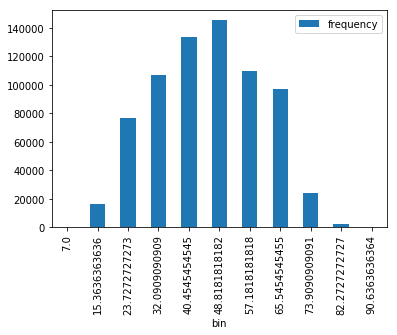

In [520]:
pd.DataFrame(
    list(zip(*age_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar')
plt.show()

### 3. transfering

In [ ]:
#TOB050	Ã–verfÃ¶ring
#TOB104	BANK VIA TELEFON
#TOB490	Ã–verfÃ¶ring via telefon 
#TOB552	Ã–verfÃ¶ring via Internet
#TOB553	Egen Ã¶verfÃ¶ring



#### in the transfering type of transactions it can be self transfer or transfer to others, need to be able to identify only the transfer to others, as those are the actual costs. also needs to identify only the transfer from the others, as those are the actual inflows. 
##### (1) try to identify relationships with the transactions that can cancel each other

In [6]:
#remove for sure income, cost transaction types
trx_sample=spark.sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 \
where (round(amount,2)>0 or round(amount,2)<0 ) and \
transtypecd not in ("TOB153", "TOB155", "TOB390", "TOB407", "TOB452", "TOB500", "TOB588", "TOB954", \
"TOB218", "TOB287", "TOB409", "TOB946", \
"TOB335", "TOB625", "TOB707", \
"TOB364", "TOB486", "TOB522", "TOB549", "TOB550", "TOB551", "TOB555", "TOB563", "TOB801", \
"TOB366", "TOB571", "TOB573",  \
"TOB261", "TOB602", \
"TOB349", "TOB353", "TOB663", "TOB665", "TOB255", "TOB256", \
"TOB873", "TOB852", \
"TOB583", "TOB584") \
sort by partygenid, transactiondate ')\
                .withColumn("abs_amt", F.abs(F.col("amount")))

In [65]:
trx_sample.printSchema

<bound method DataFrame.printSchema of DataFrame[partygenid: string, primaryaccountholder: binary, agreementgenid: int, productgenid: binary, transtypecd: string, transactiondate: date, accountingtypecd: string, channeltypecd: string, amount: decimal(18,2), bankid: int, secaccounttypecd: string, secclearingnum: decimal(5,0), secaccountnum: string, secagreementgenid: int, secpartygenid: string, secproductgenid: binary, channelgenid: int, transactiongenid: int, systemsourcecd: string, identificationmethodcd: string, paymentroutinecd: string, secbic: string, clearingnum: decimal(5,0), cardtransactionchannelcd: string, transactioninfo: string, kanalgenid: string, transactionmonth: int, transactiontype: string, transactiongroupcd: string, transactiongroup: string, birthdate: date, age: int, gender: string, customerstartdate: string, abs_amt: decimal(18,2)]>

In [7]:
# assume all the transactions among the swedbank accounts will have the same transtypecd but with different direction of the amount.
trx_sample_1=trx_sample.orderBy("partygenid", "transactiondate", "transtypecd", "abs_amt", "amount")

In [8]:
trx_sample_1.show(5)

+----------------+--------------------+--------------+--------------------+-----------+---------------+----------------+-------------+---------+------+----------------+--------------+-------------+-----------------+----------------+--------------------+------------+----------------+--------------+----------------------+----------------+------+-----------+------------------------+---------------+-------------+----------------+--------------------+------------------+--------------------+----------+---+------+-----------------+--------+
|      partygenid|primaryaccountholder|agreementgenid|        productgenid|transtypecd|transactiondate|accountingtypecd|channeltypecd|   amount|bankid|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|   secpartygenid|     secproductgenid|channelgenid|transactiongenid|systemsourcecd|identificationmethodcd|paymentroutinecd|secbic|clearingnum|cardtransactionchannelcd|transactioninfo|   kanalgenid|transactionmonth|     transactiontype|transactio

In [304]:
trx_sample_pd=trx_sample_1.toPandas()

In [305]:
trx_sample_pd.to_csv(os.path.join('~/repos', 'trx_sample' + '.csv'), encoding='utf-8')

In [133]:
%time
trx_sample.count()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


10000

In [9]:
from pyspark.sql.window import Window

In [10]:
trx_window = Window.partitionBy("partygenid").orderBy("transactiondate")

In [11]:
trx_window_2 = Window.partitionBy("partygenid").orderBy("partygenid")

In [12]:
# working with sorted trx_sample_1
# map transactions with opposite directions among same type of accounts
trx_sample_adj=trx_sample_1\
                         .withColumn("lag_id", F.lag(trx_sample_1.partygenid).over(trx_window))\
                         .withColumn("lag_amt",F.lag(trx_sample_1.amount).over(trx_window))\
                         .withColumn("lag_date", F.lag(trx_sample_1.transactiondate).over(trx_window_2))\
                         .withColumn("check", F.when((trx_sample_1.partygenid==F.lag(trx_sample_1.partygenid).over(trx_window)) & \
                        (trx_sample_1.amount+F.lag(trx_sample_1.amount).over(trx_window) == 0) & \
                        (trx_sample_1.transactiondate==F.lag(trx_sample_1.transactiondate).over(trx_window_2)) & \
                         (trx_sample_1.transtypecd==F.lag(trx_sample_1.transtypecd).over(trx_window_2)),1).otherwise(0))\
                        .withColumn("check_2", F.when((trx_sample_1.partygenid==F.lead(trx_sample_1.partygenid).over(trx_window)) & \
                        (trx_sample_1.amount+F.lead(trx_sample_1.amount).over(trx_window) == 0) & \
                        (trx_sample_1.transactiondate==F.lead(trx_sample_1.transactiondate).over(trx_window_2)) & \
                        (trx_sample_1.transtypecd==F.lead(trx_sample_1.transtypecd).over(trx_window_2)),1).otherwise(0))\
                        .withColumn("sum_check", F.col("check")+F.col("check_2"))\
                        .drop("check", "check_2")
#trx_sample_adj.columns

In [139]:
trx_sample_adj.filter((F.col('check')==1) | (F.col('check_2')==1)).groupby("transtypecd").count().sort(F.desc("count")).show(100)

+-----------+-----+
|transtypecd|count|
+-----------+-----+
|     TOB552|  654|
|     TOB490|   32|
|     TOB050|   20|
|     TOB680|    6|
|     TOB261|    2|
+-----------+-----+



In [140]:
trx_sample_adj.filter(F.trim(F.col('transtypecd'))=='TOB490').select("partygenid", "transtypecd","transactiondate", "amount", "abs_amt", "secproductgenid", "check","check_2", "sum_check" ).show(1000)

+----------------+-----------+---------------+---------+--------+---------------+-----+-------+---------+
|      partygenid|transtypecd|transactiondate|   amount| abs_amt|secproductgenid|check|check_2|sum_check|
+----------------+-----------+---------------+---------+--------+---------------+-----+-------+---------+
|+uI3Fc7hlnQAAA==|     TOB490|     2018-07-02| -3000.00| 3000.00|             []|    0|      1|        1|
|+uI3Fc7hlnQAAA==|     TOB490|     2018-07-02|  3000.00| 3000.00|             []|    1|      0|        1|
|/7zDwId3BN0AAA==|     TOB490|     2018-07-23|-20000.00|20000.00|             []|    0|      1|        1|
|/7zDwId3BN0AAA==|     TOB490|     2018-07-23| 20000.00|20000.00|             []|    1|      0|        1|
|/WcHN4hfmmcAAA==|     TOB490|     2018-05-04|  2000.00| 2000.00|             []|    0|      0|        0|
|/WcHN4hfmmcAAA==|     TOB490|     2018-05-08|   500.00|  500.00|             []|    0|      0|        0|
|/WcHN4hfmmcAAA==|     TOB490|     2018-05-09|

In [556]:
#remove for sure income, cost, swish transaction types
trx_sample_adj.groupby("sum_check").count().show()

+---------+--------+
|sum_check|   count|
+---------+--------+
|        1| 9618037|
|        2|      39|
|        0|10718785|
+---------+--------+



In [545]:
trx_sample_adj.filter(F.col("sum_check")==2).select("partygenid", "transactiondate", "transtypecd","transactiontype", "amount", "abs_amt", "secproductgenid", "sum_check").show(100)

+----------------+---------------+-----------+---------------+------+-------+---------------+---------+
|      partygenid|transactiondate|transtypecd|transactiontype|amount|abs_amt|secproductgenid|sum_check|
+----------------+---------------+-----------+---------------+------+-------+---------------+---------+
|GZkIKAFDUQVUBA==|     2018-08-09|     TOB399|         Avslut|  0.00|   0.00|             []|        2|
|GZcGAhUnOIR2Bg==|     2018-05-30|     TOB399|         Avslut|  0.00|   0.00|             []|        2|
|GZcGAhUnOIR2Bg==|     2018-05-30|     TOB399|         Avslut|  0.00|   0.00|             []|        2|
|GZcGAhYhM3lAYg==|     2018-06-12|     TOB399|         Avslut|  0.00|   0.00|             []|        2|
|Ii6aHU6rUqsAAA==|     2018-08-17|     TOB399|         Avslut|  0.00|   0.00|             []|        2|
|GZcGAhYiESNwdg==|     2018-06-18|     TOB399|         Avslut|  0.00|   0.00|             []|        2|
|GZcGAhZEIVKSFA==|     2018-07-03|     TOB399|         Avslut|  

In [13]:
#should remove TOB432 ISK omplacering
trx_sample_adj_fil=trx_sample_adj.filter((F.col("sum_check")==0) & (F.col("transtypecd")!="TOB432")).orderBy("partygenid", "transactiondate","abs_amt", F.desc("amount"))\
                                 .drop('lag_id','lag_amt','lag_date','sum_check')\
                                 .withColumn("check", F.when((trx_sample_adj.partygenid==F.lag(trx_sample_adj.partygenid).over(trx_window)) & \
                                 (trx_sample_adj.amount+F.lag(trx_sample_adj.amount).over(trx_window) == 0) & \
                                 (trx_sample_adj.transactiondate==F.lag(trx_sample_adj.transactiondate).over(trx_window_2)),1).otherwise(0))\
                                 .withColumn("check_2", F.when((trx_sample_adj.partygenid==F.lead(trx_sample_adj.partygenid).over(trx_window)) & \
                                 (trx_sample_adj.amount+F.lead(trx_sample_adj.amount).over(trx_window) == 0) & \
                                 (trx_sample_adj.transactiondate==F.lead(trx_sample_adj.transactiondate).over(trx_window_2)),1).otherwise(0))\
                                 .withColumn("sum_check", F.col("check")+F.col("check_2"))\
                                 .drop("check", "check_2")

In [442]:
trx_sample_adj_fil.select("partygenid", "transactiondate", "transtypecd","transactiontype", "amount", "abs_amt", "secproductgenid", "sum_check")\
.filter(F.col("sum_check")==1).show(2000)

TypeError: distinct() takes exactly 1 argument (2 given)

In [447]:
trx_sample_adj_fil.filter(F.col("sum_check")==1).select("transactiontype").groupby("transactiontype").count().show(2000)

+--------------------+-------+
|     transactiontype|  count|
+--------------------+-------+
|         Reseräkning|      3|
|          Autogiro F|      1|
|        KREDITAVGIFT|      2|
|           ISK UTTAG|  32827|
|Slutlikvid lägenh...|     27|
|               ROBUR|   1353|
|Rättelse Bankomat...|    102|
|         Studiehjälp|   1499|
|Sparbankernas pen...|    132|
|  Bet-uppdrag utland|      3|
|    KÖP AV POSTVÄXEL|     39|
|Överflyttning sko...|      2|
|    Sälj-Värdepapper|      4|
|Myntinsättningsau...|     16|
|      IP-Utbetalning|    624|
|   SERVICEBOX LOOMIS|      1|
|FINANSIELL ÖVERFÖ...|      1|
|          Eget uttag|      1|
|SUNDRY CREDIT FUN...|      1|
|Avgift för transa...|      1|
|         Valutaaffär|      1|
|      Dagsersättning|    172|
|           Utdelning|     56|
|              Avslut|   1286|
|           Sparränta|     19|
|    Extra amortering|      3|
|       Lån/placering|    394|
|       Bostadsbidrag|     76|
|Mottagande bank k...|      2|
|      I

In [439]:
trx_sample_adj_fil.groupby("sum_check").count().show()

+---------+--------+
|sum_check|   count|
+---------+--------+
|        1| 2799358|
|        0|10876937|
+---------+--------+



In [450]:
trx_sample_adj_fil.filter((F.col("sum_check")==0)).groupby("secclearingnum").count().orderBy(F.desc("count")).show()

+--------------+--------+
|secclearingnum|   count|
+--------------+--------+
|          null|10069884|
|           118|   88112|
|           331|   48864|
|           997|   42637|
|           124|   31881|
|           695|   25570|
|          9272|   23365|
|          9252|   21416|
|          9271|   19093|
|           799|   15396|
|           153|   15343|
|           116|   14255|
|           286|   14027|
|          9270|   12391|
|           401|   11836|
|             0|   11143|
|          9023|    9788|
|          9022|    9530|
|          9024|    9523|
|          9420|    9522|
+--------------+--------+
only showing top 20 rows



In [448]:
trx_sample_adj_fil.filter((F.col("sum_check")==0) & F.lower(F.col("transactiontype")).like("%överföring%")).groupby("transactioninfo").count().orderBy(F.desc("count")).show()

+---------------+------+
|transactioninfo| count|
+---------------+------+
|               |511272|
|832799442407798|288601|
|832799048832662|201668|
|     0000000000| 63032|
|832796934680379| 44264|
|842449249865487| 31288|
|      Periodisk| 28193|
|     KAPITALINV| 19513|
|     SV LIKVIDI| 19031|
|      Klarna AB| 16832|
|890119641829735| 15399|
|     ALLEMANSFO| 13878|
|     SV OBLIGAT| 13634|
|     Allemansfo| 13299|
|           Hyra| 11682|
|     Swedbank R| 11131|
|      Räntefond|  9547|
|     Absolutavk|  9196|
|     Svensk Lik|  8467|
|      MIXFONDEN|  7934|
+---------------+------+
only showing top 20 rows



In [55]:
trx_sample_adj_fil_remain=\
            trx_sample_adj_fil\
            .filter((F.col("sum_check")==0) & (F.col("transtypecd").isin("TOB050", "TOB552", "TOB490", "TOB104", "TOB553")))\
            .groupby("partygenid", "transactionmonth", "transtypecd")\
            .agg(F.sum(F.col("amount")), F.count(F.col("amount")))\
            .withColumn('sum_income', F.col("sum(amount)"))\
            .withColumn('count_income', F.col("count(amount)"))\
            .drop('sum(amount)','count(amount)')\
            .orderBy("partygenid", "transactionmonth", "transtypecd")

In [463]:
trx_sample_adj_fil\
            .filter((F.col("sum_check")==0) & (F.col("transtypecd").isin("TOB050", "TOB552", "TOB490", "TOB104", "TOB553")))\
            .count()

4958796

In [468]:
trx_sample_adj_fil.select("partygenid", "transactionmonth", "transtypecd", "amount", "transactioninfo", "secclearingnum", "clearingnum", "birthdate")\
            .filter((F.col("sum_check")==0) & (F.col("transtypecd").isin("TOB366", "TOB409"))).show(100)

+----------------+----------------+-----------+--------+----------------+--------------+-----------+----------+
|      partygenid|transactionmonth|transtypecd|  amount| transactioninfo|secclearingnum|clearingnum| birthdate|
+----------------+----------------+-----------+--------+----------------+--------------+-----------+----------+
|+0zH4MuyWtUAAA==|          201805|     TOB409|  675.00|19610709XXXXXXXX|          null|      89011|1961-07-09|
|+A2dwo5/f0wAAA==|          201807|     TOB409| 4400.00|19800504XXXXXXXX|          null|      89011|1980-05-04|
|0yPTcyVKlP8AAA==|          201805|     TOB366|10000.00|          141120|          null|      81059|1945-11-27|
|0yPTcyVKlP8AAA==|          201806|     TOB366| 2320.00|          162162|          null|      81059|1945-11-27|
|3CNs8AcahXkAAA==|          201805|     TOB366|10000.00|          144193|          null|      81059|1963-03-05|
|3CNs8AcahXkAAA==|          201806|     TOB366|  320.00|          155176|          null|      81059|1963

In [473]:
sample=spark.sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where birthdate="1988-03-05" \
sort by partygenid, transactiondate, abs(amount)').toPandas()

In [496]:
sample=spark.sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where birthdate="2013-04-10" \
sort by partygenid, transactiondate, abs(amount)').toPandas()

In [497]:
sample.to_csv(os.path.join('~/repos', 'trx_sample_onecustomer_4' + '.csv'), encoding='utf-8')

#### look into regular transactions

In [17]:
spark.conf.get("spark.sql.shuffle.partitions")

u'200'

In [24]:
#use trx_sample_adj_fil_remain
trx_sample_adj_fil_remain_=\
trx_sample_adj_fil.filter((F.col("sum_check")==0))\
.withColumn("day",F.date_format(F.col("transactiondate"), "d"))\
.select("partygenid", "transtypecd", "transactiondate", "amount", "secaccounttypecd", \
"secclearingnum", "secaccountnum", "secagreementgenid",  "secpartygenid", "day")\
.orderBy("partygenid", "day", "transtypecd", "amount")

In [25]:
trx_sample_adj_fil_remain_.show(100)

+----------------+-----------+---------------+---------+----------------+--------------+-------------+-----------------+----------------+---+
|      partygenid|transtypecd|transactiondate|   amount|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|   secpartygenid|day|
+----------------+-----------+---------------+---------+----------------+--------------+-------------+-----------------+----------------+---+
|++2xsgKHSs0AAA==|     TOB050|     2018-08-13|  3750.00|            null|          null|         null|        171391196|0Su6PInHwSEAAA==| 13|
|++2xsgKHSs0AAA==|     TOB382|     2018-08-16| -2000.00|            null|          null|         null|             null|++2xsgKHSs0AAA==| 16|
|++2xsgKHSs0AAA==|     TOB382|     2018-07-16|  -300.00|            null|          null|         null|             null|++2xsgKHSs0AAA==| 16|
|++2xsgKHSs0AAA==|     TOB050|     2018-05-09| 11500.00|            null|          null|         null|        171391196|BQYnCVcWAAEiNQ==|  9|
|++IXJ

### look at other transaction types --överföring

In [173]:
household.filter(F.col('transtypecd')=="TOB553").select('sec_role').groupby('sec_role').count().show()

+--------+-------+
|sec_role|  count|
+--------+-------+
|      01| 133365|
|    null| 189848|
|      00|1040089|
|      05|   3580|
|      03|     11|
|      02|   7013|
+--------+-------+



In [177]:
household.filter((F.col('transtypecd')=="TOB553") & (F.col('sec_role').isNull())).groupby('transactioninfo').count().sort(F.desc('count')).show(50)

+---------------+-----+
|transactioninfo|count|
+---------------+-----+
|       HUSKONTO|  919|
|      VINSTSPAR|  653|
|       Sparande|  571|
|     PLACERINGS|  519|
|           spar|  481|
|         PLACER|  463|
|       sparande|  427|
|     SERVICEKON|  409|
|      SPARKONTO|  384|
|     VINNARKONT|  368|
|     Överföring|  341|
|         e-spar|  320|
|           Spar|  298|
|          spara|  296|
|     överföring|  294|
|            LÅN|  293|
|          Spara|  257|
|       SPARANDE|  225|
|         E-spar|  163|
|           EGET|  154|
|     ÖVERFÖRING|  113|
|        e-konto|  105|
|            Lån|  103|
|           SPAR|  103|
|           EGEN|  102|
|     Månadsspar|  100|
|            lån|   97|
|      LÅNEKONTO|   94|
|     VILLAKONTO|   88|
|          espar|   86|
|      sparkonto|   75|
|     månadsspar|   75|
|          SPARA|   72|
|     EGEN ÖVERF|   71|
|       Semester|   69|
|     Barnbidrag|   69|
|       semester|   67|
|     SPARANDEKO|   66|
|         Huslån

In [99]:
transfer=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where lower(transactiontype) like "%överföring%" sort by partygenid, transactiondate')\
                .withColumn('count', F.lit(1))\
                .withColumn('selftrans',F.when((F.col('partygenid')==F.col('secpartygenid')),1).otherwise(0))

In [103]:
transfer.select('transactiontype','secaccounttypecd').sort('transactiontype').distinct().show()

+--------------------+----------------+
|     transactiontype|secaccounttypecd|
+--------------------+----------------+
| Egen int överföring|            null|
|     Egen överföring|            null|
|FINANSIELL ÖVERFÖ...|            null|
|    Retur överföring|            null|
|ÖVERFÖRING       ...|            null|
|          Överföring|            null|
|          Överföring|             KTO|
|      Överföring lån|            null|
|      Överföring lån|             KTO|
|Överföring via In...|             KTO|
|Överföring via In...|            null|
|Överföring via te...|            null|
+--------------------+----------------+



In [2]:
TOB553=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd="TOB553"')

In [8]:
TOB553.groupby('accountingtypecd').count().show()

+----------------+------+
|accountingtypecd| count|
+----------------+------+
|             IN |885480|
+----------------+------+



In [51]:
check=TOB553.select('partygenid','amount','secaccounttypecd','secclearingnum','secaccountnum','secagreementgenid','clearingnum','transactioninfo','secpartygenid')\
      .withColumn('selftrans',F.when((F.col('partygenid')==F.col('secpartygenid')),1).otherwise(0))\
      .filter(F.col('selftrans')==0)
#   .groupby('selftrans').count().show()

In [59]:
check.show(5)

+----------------+-------+----------------+--------------+-------------+-----------------+-----------+---------------+----------------+---------+
|      partygenid| amount|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|clearingnum|transactioninfo|   secpartygenid|selftrans|
+----------------+-------+----------------+--------------+-------------+-----------------+-----------+---------------+----------------+---------+
|0RjRIqZvqO0AAA==|3500.00|            null|          null|         null|        165701658|      83279|            b-m|GZcGAhY3FYiEIw==|        0|
|0RjRIqZvqO0AAA==|3500.00|            null|          null|         null|        165701658|      83279|            b-m|GZcGAhY3FYiEIw==|        0|
|0RjRIqZvqO0AAA==|3500.00|            null|          null|         null|        165701658|      83279|            b-m|GZcGAhY3FYiEIw==|        0|
|1Vxwcy/h2e4AAA==| 500.00|            null|          null|         null|             null|      84202|    79182000581|      

In [70]:
#(F.col('secagreementgenid').isNotNull()) &
check\
.withColumn('selftrans_ad',\
F.when(((F.col('clearingnum').isNotNull()) & (F.col('transactioninfo').isNotNull())) ,1)\
.otherwise(0))\
.filter(F.col('selftrans')==0 & F.col('selftrans_ad')==0).show(100)

+----------+------+----------------+--------------+-------------+-----------------+-----------+---------------+-------------+---------+------------+
|partygenid|amount|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|clearingnum|transactioninfo|secpartygenid|selftrans|selftrans_ad|
+----------+------+----------------+--------------+-------------+-----------------+-----------+---------------+-------------+---------+------------+
+----------+------+----------------+--------------+-------------+-----------------+-----------+---------------+-------------+---------+------------+



In [20]:
TOB552=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd="TOB552"')

In [159]:
#what are these three digit clearing number?
#when it is in, then it is only own transfer, only when it is out, it could be to other banks.
TOB552.select('partygenid','amount','secaccounttypecd','secclearingnum','secaccountnum','secagreementgenid','clearingnum','transactioninfo','secpartygenid', 'accountingtypecd')\
      .withColumn('selftrans',F.when((F.col('partygenid')==F.col('secpartygenid')),1).otherwise(0))\
      .withColumn('selftrans_ad', F.when((F.col('secclearingnum').isNotNull()) & (F.col('secaccountnum').isNotNull()),0)\
      .otherwise(1))\
      .withColumn('sec_fullnum', F.concat(F.col("secclearingnum"), F.col("secaccountnum")))\
      .withColumn('sec_clearingnum', F.substring(F.col("sec_fullnum"), 0, 4))\
      .filter((F.col('selftrans')==0) & (F.col('selftrans_ad')==0) & (F.trim(F.col('accountingtypecd'))=='IN'))\
      .groupby('secclearingnum').count().sort(F.desc('secclearingnum')).show(100)

+--------------+-----+
|secclearingnum|count|
+--------------+-----+
|           997| 1295|
|           993|    1|
|           985|   41|
|           981|    3|
|           980|   12|
|           963|   32|
|           950|    1|
|           947|   26|
|           942|   13|
|           926|   14|
|           916|    3|
|           914|    6|
|           879|   27|
|           866|  261|
|           815|    4|
|           766|   42|
|           763|    6|
|           641|    1|
|           617|   17|
|           564|   16|
|           551|   19|
|           544|    3|
|           533|   11|
|           526|   79|
|           517|   60|
|           509|   27|
|           508|    8|
|           478|    2|
|           472|   15|
|           431|   18|
|           365|    3|
|           358|   55|
|           336|    5|
|           323|    1|
|           252|    7|
|           244|   63|
|           227|    4|
|           217|    2|
|           165|    3|
|           133|   16|
|          

In [153]:
#what are these three digit clearing number?
TOB552.withColumn('selftrans',F.when((F.col('partygenid')==F.col('secpartygenid')),1).otherwise(0))\
      .withColumn('selftrans_ad', F.when((F.col('secclearingnum').isNotNull()) & (F.col('secaccountnum').isNotNull()),0)\
      .otherwise(1))\
      .withColumn('sec_fullnum', F.concat(F.col("secclearingnum"), F.col("secaccountnum")))\
      .withColumn('sec_clearingnum', F.substring(F.col("transactioninfo"), 0, 4))\
      .filter((F.col('selftrans')==0) & (F.col('selftrans_ad')==0) & (F.trim(F.col('accountingtypecd'))=='IN') & (F.col("transactioninfo").isNotNull()))\
      .groupby('sec_clearingnum','secclearingnum').count().sort(F.desc('count')).show(100)
#   .withColumn('sec_clearingnum', F.substring(F.col("sec_fullnum"), 0, 4))\

+---------------+--------------+-----+
|sec_clearingnum|secclearingnum|count|
+---------------+--------------+-----+
|           8899|           997| 1295|
|           0786|           866|  261|
|           0752|           526|   79|
|           0724|           244|   63|
|           0751|           517|   60|
|           0711|           117|   58|
|           0735|           358|   55|
|           0776|           766|   42|
|           0798|           985|   41|
|           0796|           963|   32|
|           0787|           879|   27|
|           0750|           509|   27|
|           0794|           947|   26|
|           0755|           551|   19|
|           0743|           431|   18|
|           0761|           617|   17|
|           0756|           564|   16|
|           0713|           133|   16|
|           0747|           472|   15|
|           0792|           926|   14|
|           0794|           942|   13|
|           0798|           980|   12|
|           0753|        

In [154]:
TOB050=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd="TOB050"')

In [110]:
TOB050.show(10)

+----------------+--------------------+--------------+--------------------+-----------+---------------+----------------+-------------+--------+------+----------------+--------------+-------------+-----------------+----------------+--------------------+------------+----------------+--------------+----------------------+----------------+------+-----------+------------------------+----------------+-------------+----------------+---------------+------------------+--------------------+----------+---+------+-----------------+
|      partygenid|primaryaccountholder|agreementgenid|        productgenid|transtypecd|transactiondate|accountingtypecd|channeltypecd|  amount|bankid|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|   secpartygenid|     secproductgenid|channelgenid|transactiongenid|systemsourcecd|identificationmethodcd|paymentroutinecd|secbic|clearingnum|cardtransactionchannelcd| transactioninfo|   kanalgenid|transactionmonth|transactiontype|transactiongroupcd|    transa

In [156]:
TOB552.groupby('secclearingnum').count().sort(F.desc('secclearingnum')).show(100)

+--------------+-----+
|secclearingnum|count|
+--------------+-----+
|          9924|    1|
|          9706|    1|
|          9700|   79|
|          9688|    4|
|          9670|  314|
|          9660|   56|
|          9652|  226|
|          9651|   36|
|          9650|   23|
|          9647|    1|
|          9644|    1|
|          9643|    1|
|          9641|    1|
|          9640|  124|
|          9630|  902|
|          9592|    2|
|          9563|    1|
|          9562|   30|
|          9559|   31|
|          9558|   32|
|          9557|   37|
|          9556|   51|
|          9555|   22|
|          9554|   30|
|          9553| 1499|
|          9552| 1557|
|          9551| 2706|
|          9550| 1893|
|          9470|    2|
|          9469|  585|
|          9420| 7040|
|          9410|   13|
|          9390|  530|
|          9281|  462|
|          9272|18448|
|          9271|14165|
|          9270| 9236|
|          9252|12080|
|          9251|  138|
|          9235|  908|
|          

In [104]:
TOB050.select('partygenid','amount','secaccounttypecd','secclearingnum','secaccountnum','secagreementgenid','clearingnum','transactioninfo','secpartygenid', 'accountingtypecd')\
.withColumn('selftrans',F.when((F.col('partygenid')==F.col('secpartygenid')),1).otherwise(0))\
.withColumn('selftrans_ad', F.when(((F.col('secclearingnum').isNull()) & (F.col('secaccountnum').isNull())),1)\
.otherwise(0))\
.filter((F.col('selftrans_ad')==1) & (F.col('selftrans')==0)).show(100)
#.filter((F.col('selftrans')==1) & (F.trim(F.col('accountingtypecd'))=='IN')).show(100)

+----------------+---------+----------------+--------------+-------------+-----------------+-----------+----------------+----------------+----------------+---------+------------+
|      partygenid|   amount|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|clearingnum| transactioninfo|   secpartygenid|accountingtypecd|selftrans|selftrans_ad|
+----------------+---------+----------------+--------------+-------------+-----------------+-----------+----------------+----------------+----------------+---------+------------+
|/L61VE2OcPEAAA==|  4000.00|            null|          null|         null|        161308668|      82016|         Fredrik|GZcGAhYhVUZ4FA==|             IN |        0|           1|
|/L61VE2OcPEAAA==|  4000.00|            null|          null|         null|        161308668|      82016|         Fredrik|GZcGAhYhVUZ4FA==|             IN |        0|           1|
|/L61VE2OcPEAAA==|  4000.00|            null|          null|         null|        161308668|      82016| 

In [88]:
#TOB104 
TOB104=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd="TOB104"')
TOB104.filter((F.col('transtypecd')=='TOB104') & (F.trim(F.col('accountingtypecd'))=='UT'))\
      .select('partygenid','transactiondate','transtypecd', 'amount','accountingtypecd' ,'secaccounttypecd','secclearingnum','secaccountnum','secagreementgenid','clearingnum','transactioninfo')\
      .sort('partygenid', 'transactiondate', F.abs(F.col('amount')))\
      .groupby('secclearingnum').count().show()

+--------------+-----+
|secclearingnum|count|
+--------------+-----+
|          null|19889|
+--------------+-----+



In [93]:
#TOB490 
TOB490=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd="TOB490"')
TOB490.filter((F.col('transtypecd')=='TOB490'))\
      .select('partygenid','agreementgenid','transactiondate','transtypecd', 'amount','accountingtypecd' ,'secaccounttypecd','secclearingnum','secaccountnum','secagreementgenid','clearingnum','transactioninfo')\
      .sort('partygenid', 'transactiondate', F.abs(F.col('amount')))\
      .groupby('secclearingnum').count().show()

+--------------+------+
|secclearingnum| count|
+--------------+------+
|          null|339053|
+--------------+------+



In [105]:
TOB490=sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where transtypecd="TOB490"')

In [109]:
TOB490.select('partygenid','amount','secaccounttypecd','secclearingnum','secaccountnum','secagreementgenid','clearingnum','transactioninfo','secpartygenid', 'accountingtypecd')\
.withColumn('selftrans',F.when((F.col('partygenid')==F.col('secpartygenid')),1).otherwise(0))\
.withColumn('selftrans_ad', F.when(((F.col('secclearingnum').isNull()) & (F.col('secaccountnum').isNull())),1)\
.otherwise(0))\
.show(100)

+----------------+---------+----------------+--------------+-------------+-----------------+-----------+---------------+-------------+----------------+---------+------------+
|      partygenid|   amount|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|clearingnum|transactioninfo|secpartygenid|accountingtypecd|selftrans|selftrans_ad|
+----------------+---------+----------------+--------------+-------------+-----------------+-----------+---------------+-------------+----------------+---------+------------+
|4x1lini4E7kAAA==|  8000.00|            null|          null|         null|             null|      84806|    71682805492|             |             IN |        0|           1|
|4x1lini4E7kAAA==| -7000.00|            null|          null|         null|             null|      84806|     9245865150|             |             UT |        0|           1|
|4x1lini4E7kAAA==| -8000.00|            null|          null|         null|             null|      84806|     9245865150|     

In [94]:
TOB_transfer=spark.sql('select a.*, b.customerroletype as sec_role_onmainagg, c.customerroletype as main_role_onsecagg from ddp_steer.p901cyo_trx_sample_201805_201808 as a \
left join (select agreementgenid, partygenid_role, customerroletype from ddp_central.src_sdw_agreementcustomerrole \
) as b \
on a.agreementgenid=b.agreementgenid and a.secpartygenid=base64(b.partygenid_role) \
left join (select agreementgenid, partygenid_role, customerroletype from ddp_central.src_sdw_agreementcustomerrole \
) as c \
on a.secagreementgenid=c.agreementgenid and a.partygenid=base64(c.partygenid_role) \
where transtypecd in ("TOB050","TOB104", "TOB490", "TOB552", "TOB553")')

In [95]:
TOB_transfer_excself=TOB_transfer.withColumn('owntransfer_553', F.when((F.col('transtypecd')=='TOB553'),1).otherwise(0))\
            .withColumn('owntransfer_050', F.when(((F.col('transtypecd')=='TOB050')&(F.col('secaccounttypecd').isNull())&(F.col('secclearingnum').isNull())&(F.col('secaccountnum').isNull())&(F.col('secagreementgenid').isNotNull())) & ((F.col('sec_role_onmainagg').isNotNull()) | (F.col('main_role_onsecagg').isNotNull())),1).otherwise(0))\
            .withColumn('owntransfer_552', F.when(((F.col('transtypecd')=='TOB552')&(F.col('secaccounttypecd').isNull())&(F.col('secclearingnum').isNull())&(F.col('secaccountnum').isNull())&(F.col('secagreementgenid').isNotNull())) & ((F.col('sec_role_onmainagg').isNotNull()) | (F.col('main_role_onsecagg').isNotNull())),1).otherwise(0))\
            .filter((F.col('owntransfer_553')!=1) | (F.col('owntransfer_050')!=1) |(F.col('owntransfer_552')!=1))

### identify transfer to other financial institutions but not a payment

##### http://www-2.danskebank.com/link/Bankernaskontonummer
##### http://clearingnummer.info/
##### https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_clearingnummer_till_svenska_banker
##### https://www.bankgirot.se/globalassets/dokument/anvandarmanualer/bankernaskontonummeruppbyggnad_anvandarmanual_sv.pdf

### saw some tables in ddp_central, e.g. ac_depo_transaction_avanza_nordnet_trimmed, ac_monthly_aggr_outgoing_private_trans_to_other_bank_per_bank

In [264]:
#and (secclearingnum<80000 or secclearingnum>89999)  transtypecd in ("TOB552", "TOB050", "TOB486","TOB550", "TOB551") and  
#trx_transout_type=(str('TOB552'),str('TOB050'),str('TOB521'),str('TOB553'),str('TOB520'),str('TOB588'),str('TOB430'),str('TOB490'))
trx_transout=spark.sql('select * from ddp_steer.p901cyo_trx_sample_201805_201808 where trim(accountingtypecd)="UT" and \
transtypecd in ("TOB552", "TOB050") sort by partygenid, transactiondate limit 100000' )\
                .withColumn("abs_amt", F.abs(F.col("amount")))\
                .withColumn("counterparty", (F.when((F.trim(F.col("secclearingnum"))<=9569) & (F.trim(F.col("secclearingnum"))>=9550), 'Avanza'))\
                            .when((F.substring('secclearingnum',1,4)<=8999) & (F.substring('secclearingnum',1,4)>=8000), 'Swedbank')\
                            .when((F.substring('secclearingnum',1,4)<=6999) & (F.substring('secclearingnum',1,4)>=6000), 'Handelsbanken')\
                            .when((F.substring('secclearingnum',1,4)<=9279) & (F.substring('secclearingnum',1,4)>=9270), 'ICA Banken')\
                            .when((F.substring('secclearingnum',1,4)<=9179) & (F.substring('secclearingnum',1,4)>=9170), 'IKANO Banken')\
                            .when((F.substring('secclearingnum',1,4)<=9109) & (F.substring('secclearingnum',1,4)>=9100), 'Nordnet')\
                            .when((F.substring('secclearingnum',1,4)<=9289) & (F.substring('secclearingnum',1,4)>=9280), 'Resurs Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9259) & (F.substring('secclearingnum',1,4)>=9250), 'SBAB')\
                            .when((F.substring('secclearingnum',1,4)<=9169) & (F.substring('secclearingnum',1,4)>=9150), 'Skandiabanken')\
                            .when((F.substring('secclearingnum',1,4)<=9449) & (F.substring('secclearingnum',1,4)>=9400), 'Forex Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9469) & (F.substring('secclearingnum',1,4)>=9460), 'GE Money Bank')\
                            .when((F.substring('secclearingnum',1,4)<=2399) & (F.substring('secclearingnum',1,4)>=2300), 'Ålandsbanken')\
                            .when((F.substring('secclearingnum',1,4)<=9199) & (F.substring('secclearingnum',1,4)>=9190), 'DNB')\
                            .when((F.substring('secclearingnum',1,4)<=9689) & (F.substring('secclearingnum',1,4)>=9680), 'Bluestep')\
                            .when((F.substring('secclearingnum',1,4)<=9239) & (F.substring('secclearingnum',1,4)>=9230), 'Marginalen Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9649) & (F.substring('secclearingnum',1,4)>=9640), 'Nordax Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9469) & (F.substring('secclearingnum',1,4)>=9460), 'Santander')\
                            .when((F.substring('secclearingnum',1,4)<=9579) & (F.substring('secclearingnum',1,4)>=9570), 'Sparbanken Syd')\
                            .when((F.substring('secclearingnum',1,4)<=9349) & (F.substring('secclearingnum',1,4)>=9300), 'Sparbanken Öresund')\
                            .when(((F.substring('secclearingnum',1,4)<=1399) & (F.substring('secclearingnum',1,4)>=1200)) | \
                                  ((F.substring('secclearingnum',1,4)<=2499) & (F.substring('secclearingnum',1,4)>=2400)) | \
                                  ((F.substring('secclearingnum',1,4)<=9189) & (F.substring('secclearingnum',1,4)>=9180)), 'Danske Bank')\
                            .when(((F.substring('secclearingnum',1,4)<=5999) & (F.substring('secclearingnum',1,4)>=5000)) | \
                                  ((F.substring('secclearingnum',1,4)<=9124) & (F.substring('secclearingnum',1,4)>=9120)) | \
                                  ((F.substring('secclearingnum',1,4)<=9149) & (F.substring('secclearingnum',1,4)>=9130)), 'SEB')\
                            .when(((F.substring('secclearingnum',1,4)<=9029) & (F.substring('secclearingnum',1,4)>=9020)) | \
                                  ((F.substring('secclearingnum',1,4)<=3409) & (F.substring('secclearingnum',1,4)>=3400)) | \
                                  ((F.substring('secclearingnum',1,4)<=9069) & (F.substring('secclearingnum',1,4)>=9060)), 'Länsförsäkningar')\
                            .when(((F.substring('secclearingnum',1,4)<=1199) & (F.substring('secclearingnum',1,4)>=1100)) | \
                                  ((F.substring('secclearingnum',1,4)<=1999) & (F.substring('secclearingnum',1,4)>=1449)) | \
                                  ((F.substring('secclearingnum',1,4)<=3999) & (F.substring('secclearingnum',1,4)>=3410)) | \
                                  ((F.substring('secclearingnum',1,4)<=4999) & (F.substring('secclearingnum',1,4)>=4000)) | \
                                  ((F.substring('secclearingnum',1,4)<=9549) & (F.substring('secclearingnum',1,4)>=9500)) | \
                                  ((F.substring('secclearingnum',1,4)<=9969) & (F.substring('secclearingnum',1,4)>=9960)) | \
                                  ((F.substring('secclearingnum',1,4)<=3399) & (F.substring('secclearingnum',1,4)>=3000)), 'Nordea')\
                            .when((F.trim(F.col('secclearingnum'))==0), '0')\
                            .otherwise('Other'))
#trx_transout.columns

In [300]:
trx_transout=trx_sample_adj.filter((F.col('sum_check')!=1))\
                            .withColumn("counterparty", (F.when((F.trim(F.col("secclearingnum"))<=9569) & (F.trim(F.col("secclearingnum"))>=9550), 'Avanza'))\
                            .when((F.substring('secclearingnum',1,4)<=8999) & (F.substring('secclearingnum',1,4)>=8000), 'Swedbank')\
                            .when((F.substring('secclearingnum',1,4)<=6999) & (F.substring('secclearingnum',1,4)>=6000), 'Handelsbanken')\
                            .when((F.substring('secclearingnum',1,4)<=9279) & (F.substring('secclearingnum',1,4)>=9270), 'ICA Banken')\
                            .when((F.substring('secclearingnum',1,4)<=9179) & (F.substring('secclearingnum',1,4)>=9170), 'IKANO Banken')\
                            .when((F.substring('secclearingnum',1,4)<=9109) & (F.substring('secclearingnum',1,4)>=9100), 'Nordnet')\
                            .when((F.substring('secclearingnum',1,4)<=9289) & (F.substring('secclearingnum',1,4)>=9280), 'Resurs Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9259) & (F.substring('secclearingnum',1,4)>=9250), 'SBAB')\
                            .when((F.substring('secclearingnum',1,4)<=9169) & (F.substring('secclearingnum',1,4)>=9150), 'Skandiabanken')\
                            .when((F.substring('secclearingnum',1,4)<=9449) & (F.substring('secclearingnum',1,4)>=9400), 'Forex Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9469) & (F.substring('secclearingnum',1,4)>=9460), 'GE Money Bank')\
                            .when((F.substring('secclearingnum',1,4)<=2399) & (F.substring('secclearingnum',1,4)>=2300), 'Ålandsbanken')\
                            .when((F.substring('secclearingnum',1,4)<=9199) & (F.substring('secclearingnum',1,4)>=9190), 'DNB')\
                            .when((F.substring('secclearingnum',1,4)<=9689) & (F.substring('secclearingnum',1,4)>=9680), 'Bluestep')\
                            .when((F.substring('secclearingnum',1,4)<=9239) & (F.substring('secclearingnum',1,4)>=9230), 'Marginalen Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9649) & (F.substring('secclearingnum',1,4)>=9640), 'Nordax Bank')\
                            .when((F.substring('secclearingnum',1,4)<=9469) & (F.substring('secclearingnum',1,4)>=9460), 'Santander')\
                            .when((F.substring('secclearingnum',1,4)<=9579) & (F.substring('secclearingnum',1,4)>=9570), 'Sparbanken Syd')\
                            .when((F.substring('secclearingnum',1,4)<=9349) & (F.substring('secclearingnum',1,4)>=9300), 'Sparbanken Öresund')\
                            .when(((F.substring('secclearingnum',1,4)<=1399) & (F.substring('secclearingnum',1,4)>=1200)) | \
                                  ((F.substring('secclearingnum',1,4)<=2499) & (F.substring('secclearingnum',1,4)>=2400)) | \
                                  ((F.substring('secclearingnum',1,4)<=9189) & (F.substring('secclearingnum',1,4)>=9180)), 'Danske Bank')\
                            .when(((F.substring('secclearingnum',1,4)<=5999) & (F.substring('secclearingnum',1,4)>=5000)) | \
                                  ((F.substring('secclearingnum',1,4)<=9124) & (F.substring('secclearingnum',1,4)>=9120)) | \
                                  ((F.substring('secclearingnum',1,4)<=9149) & (F.substring('secclearingnum',1,4)>=9130)), 'SEB')\
                            .when(((F.substring('secclearingnum',1,4)<=9029) & (F.substring('secclearingnum',1,4)>=9020)) | \
                                  ((F.substring('secclearingnum',1,4)<=3409) & (F.substring('secclearingnum',1,4)>=3400)) | \
                                  ((F.substring('secclearingnum',1,4)<=9069) & (F.substring('secclearingnum',1,4)>=9060)), 'Länsförsäkningar')\
                            .when(((F.substring('secclearingnum',1,4)<=1199) & (F.substring('secclearingnum',1,4)>=1100)) | \
                                  ((F.substring('secclearingnum',1,4)<=1999) & (F.substring('secclearingnum',1,4)>=1449)) | \
                                  ((F.substring('secclearingnum',1,4)<=3999) & (F.substring('secclearingnum',1,4)>=3410)) | \
                                  ((F.substring('secclearingnum',1,4)<=4999) & (F.substring('secclearingnum',1,4)>=4000)) | \
                                  ((F.substring('secclearingnum',1,4)<=9549) & (F.substring('secclearingnum',1,4)>=9500)) | \
                                  ((F.substring('secclearingnum',1,4)<=9969) & (F.substring('secclearingnum',1,4)>=9960)) | \
                                  ((F.substring('secclearingnum',1,4)<=3399) & (F.substring('secclearingnum',1,4)>=3000)), 'Nordea')\
                            .when((F.trim(F.col('secclearingnum'))==0), '0')\
                            .otherwise('Other'))

In [306]:
trx_transout.head(10)

[Row(partygenid=u'+/Mz+PrKlmgAAA==', primaryaccountholder=bytearray(b'\xfb\xf33\xf8\xfa\xca\x96h\x00\x00'), agreementgenid=165427126, productgenid=bytearray(b' \x05\x05\x01\x00\x04Aa4\x85'), transtypecd=u'TOB261', transactiondate=datetime.date(2018, 5, 2), accountingtypecd=u'UT ', channeltypecd=u'POS', amount=Decimal('-220.99'), bankid=8999, secaccounttypecd=None, secclearingnum=None, secaccountnum=None, secagreementgenid=None, secpartygenid=u'+/Mz+PrKlmgAAA==', secproductgenid=bytearray(b''), channelgenid=359, transactiongenid=75080422, systemsourcecd=u'GRK', identificationmethodcd=None, paymentroutinecd=None, secbic=None, clearingnum=Decimal('88500'), cardtransactionchannelcd=u'KSV', transactioninfo=u'496160', kanalgenid=u'POSHEMK\xd6P G\xd6TEBORG H\xd6GSBO,', transactionmonth=201805, transactiontype=u'KONTOK\xd6P KORT', transactiongroupcd=u'EJR', transactiongroup=u'Ej relevant f\xf6r denna transaktionskod', birthdate=datetime.date(1985, 12, 18), age=33, gender=u'M', customerstartdat

In [274]:
trx_transout.select("secclearingnum", "counterparty").distinct().sort(F.desc("secclearingnum")).show(1000)

+--------------+-------------+
|secclearingnum| counterparty|
+--------------+-------------+
|          9553|       Avanza|
|          9420|   Forex Bank|
|          9272|   ICA Banken|
|          6090|Handelsbanken|
|          6077|Handelsbanken|
|          6067|Handelsbanken|
|          6049|Handelsbanken|
|          6042|Handelsbanken|
|          6029|Handelsbanken|
|          6020|Handelsbanken|
|          5707|          SEB|
|          5699|          SEB|
|          5421|          SEB|
|          5142|          SEB|
|          3034|       Nordea|
|           827|        Other|
|           396|        Other|
|           331|        Other|
|          null|        Other|
+--------------+-------------+



In [271]:
trx_transout.groupby("counterparty","transtypecd").count().sort(F.desc("count")).show(1000)

+------------+-----------+-----+
|counterparty|transtypecd|count|
+------------+-----------+-----+
|       Other|     TOB552|  175|
|        SBAB|     TOB552|    3|
|         SEB|     TOB552|    2|
| Danske Bank|     TOB552|    1|
+------------+-----------+-----+



In [228]:
trx_transout.groupby("counterparty").count().show()

+-------------+-----+
| counterparty|count|
+-------------+-----+
|Handelsbanken|   67|
|        Other| 9862|
|Skandiabanken|    1|
|       Avanza|   19|
|   ICA Banken|   42|
|      Nordnet|    1|
|         SBAB|    4|
|  Danske Bank|    4|
+-------------+-----+



In [284]:
prod_raw = spark.sql('select productgenid as secproductgenid, productid, productsubid, productname, productdescription, productgrouplevel1, productgrouplevel2 \
                    from ddp_central.prd_productstructgpx \
                    where bankid in ("0", "8999")')

In [286]:
trx_transout.select("partygenid", "agreementgenid", "productgenid", "secproductgenid", "secclearingnum", "secagreementgenid", "clearingnum", "transactioninfo", "counterparty").\
filter((F.col('counterparty')=="Other") & (F.col('productgenid')==F.col('secproductgenid'))).join(prod_raw, ['secproductgenid'], 'left').show(100)

+--------------------+----------------+--------------+--------------------+--------------+-----------------+-----------+---------------+------------+---------+------------+--------------------+------------------+--------------------+--------------------+
|     secproductgenid|      partygenid|agreementgenid|        productgenid|secclearingnum|secagreementgenid|clearingnum|transactioninfo|counterparty|productid|productsubid|         productname|productdescription|  productgrouplevel1|  productgrouplevel2|
+--------------------+----------------+--------------+--------------------+--------------+-----------------+-----------+---------------+------------+---------+------------+--------------------+------------------+--------------------+--------------------+
|[20 05 05 01 00 0...|+2fwsO9X+k0AAA==|     168631321|[20 05 05 01 00 0...|          null|        168631315|      84202|    79182002606|       Other| TRP00502|    KONTO   |Privatkonto         |       Privatkonto|Transaction Accounts|Li

In [299]:
#doesn't work
trx_transout.filter((F.col('agreementgenid')==168631321) | (F.trim(F.col('agreementgenid')).like("168631315"))).show(100)

+----------+--------------------+--------------+------------+-----------+---------------+----------------+-------------+------+------+----------------+--------------+-------------+-----------------+-------------+---------------+------------+----------------+--------------+----------------------+----------------+------+-----------+------------------------+---------------+----------+----------------+---------------+------------------+----------------+---------+---+------+-----------------+-------+------+-------+--------+---------+------------+
|partygenid|primaryaccountholder|agreementgenid|productgenid|transtypecd|transactiondate|accountingtypecd|channeltypecd|amount|bankid|secaccounttypecd|secclearingnum|secaccountnum|secagreementgenid|secpartygenid|secproductgenid|channelgenid|transactiongenid|systemsourcecd|identificationmethodcd|paymentroutinecd|secbic|clearingnum|cardtransactionchannelcd|transactioninfo|kanalgenid|transactionmonth|transactiontype|transactiongroupcd|transactiongroup

In [ ]:
# fuzzy matching on transaction infor